In [1]:
import sys, os
print(sys.path)
sys.path.insert(0, '/home/harishbabu/projects/PIPNet')
from collections import defaultdict
from PIL import Image
import pdb
import heapq
from adversarial.utils import unshuffle_dataloader, get_heap, undo_preprocess, get_less_activation_locations_mask, get_less_activation_locations, get_normalize_transform


['/home/harishbabu/projects/PIPNet', '/home/harishbabu/.conda/envs/hpnet3/lib/python38.zip', '/home/harishbabu/.conda/envs/hpnet3/lib/python3.8', '/home/harishbabu/.conda/envs/hpnet3/lib/python3.8/lib-dynload', '', '/home/harishbabu/.local/lib/python3.8/site-packages', '/home/harishbabu/.conda/envs/hpnet3/lib/python3.8/site-packages']


/home/harishbabu/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/harishbabu/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 118 Project dist with BYOL, HPIPNetBYOLOpt2ProtopoolProjDist
# run_path = "/home/harishbabu/projects/PIPNet/runs/117-HPIPNetBYOLOpt2NoProtopool_CUB-18-imgnet-224_with-equalize-aug_cnext26_img=224_nprotos=20_BYOL_no-KO_no-OOD_no-AL_no-TANH"

# run_path = "/home/harishbabu/projects/PIPNet/runs/119-checkingBYOLPretraining01-withCS-noBYOLjustCL"

run_path = "/home/harishbabu/projects/PIPNet/runs/126-checkingBYOL05_bpOnlyCLNotClusDesc_with-CL-ClusDesc_byol=2"

try:
    sys.path.remove('/home/harishbabu/projects/PIPNet')
except:
    pass
sys.path.insert(0, os.path.join(run_path, 'source_clone'))

print(run_path)


/home/harishbabu/projects/PIPNet/runs/126-checkingBYOL05_bpOnlyCLNotClusDesc_with-CL-ClusDesc_byol=2


In [3]:
import torch.nn as nn
import torch

import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy

from omegaconf import OmegaConf
import shutil
import pickle
import random
from tqdm import tqdm

from torchvision.datasets.folder import ImageFolder
from torch.utils.data import DataLoader
from skimage.filters import threshold_local, gaussian
import ntpath

print(sys.path)


['/home/harishbabu/projects/PIPNet/runs/126-checkingBYOL05_bpOnlyCLNotClusDesc_with-CL-ClusDesc_byol=2/source_clone', '/home/harishbabu/projects/PIPNet', '/home/harishbabu/.conda/envs/hpnet3/lib/python38.zip', '/home/harishbabu/.conda/envs/hpnet3/lib/python3.8', '/home/harishbabu/.conda/envs/hpnet3/lib/python3.8/lib-dynload', '', '/home/harishbabu/.local/lib/python3.8/site-packages', '/home/harishbabu/.conda/envs/hpnet3/lib/python3.8/site-packages']


In [4]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
from util.node import Node
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
from util.func import get_patch_size
from util.data import ModifiedLabelLoader

import torch
import torch.optim as optim


In [5]:
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()

exp_no = int(os.path.basename(run_path)[:3])

if exp_no < 77:
    if ('num_protos_per_descendant' in args) and (args.num_protos_per_descendant > 0):
        for node in root.nodes_with_children():
            node.set_num_protos(args.num_protos_per_descendant)
if exp_no == 77:
    # update num of protos per node based on num_protos_per_descendant
    if args.num_features == 0 and args.num_protos_per_descendant == 0:
        raise Exception('Either of num_features or num_protos_per_descendant must be greater than zero')
    for node in root.nodes_with_children():
        node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                                                            min_protos=args.num_features)
else:
    if ('num_protos_per_descendant' in args):
        # update num of protos per node based on num_protos_per_descendant
        if args.num_features == 0 and args.num_protos_per_descendant == 0:
            raise Exception('Either of num_features or num_protos_per_descendant must be greater than zero')
        for node in root.nodes_with_children():
            node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                                min_protos=args.num_features,\
                                split_protos=('protopool' in args) and (args.protopool == 'n'))

if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

# args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
# args = pickle.load(args_file)



------------------------- No discretization -------------------------


In [6]:
args.batch_size = 1

print(args.batch_size)
print(args.dataset)

1
CUB-18-imgnet-224


In [7]:
# ckpt_file_name = 'net_overspecific_pruned_replaced_thresh=0.5_last'
ckpt_file_name = 'net_trained_last'
# ckpt_file_name = 'net_trained_10'
# ckpt_file_name = 'net_pretrained'
epoch = ckpt_file_name.split('_')[-1]

ckpt_path = os.path.join(run_path, 'checkpoints', ckpt_file_name)
checkpoint = torch.load(ckpt_path, map_location=device)

if ckpt_file_name != 'net_trained_last':
    print('\n', (10*'-')+'WARNING: Not using the final trained model'+(10*'-'), '\n')

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)

print(args.batch_size, trainloader.batch_size)

if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

# Create a convolutional network based on arguments and add 1x1 conv layer
feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)
   
# Create a PIP-Net
net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )

# Create a PIP-Net
if ('byol' in args) and (args.byol == 'y'):
    from pipnet.pipnet import PIPNetBYOL
    net = PIPNetBYOL(num_classes=len(classes),
                        num_prototypes=num_prototypes,
                        feature_net = feature_net,
                        args = args,
                        add_on_layers = add_on_layers,
                        pool_layer = pool_layer,
                        classification_layers = classification_layers,
                        num_parent_nodes = len(root.nodes_with_children()),
                        root = root
                        )
else:
    net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )
        
net = net.to(device=device)
net = nn.DataParallel(net, device_ids = device_ids)    
net.load_state_dict(checkpoint['model_state_dict'],strict=True)
print(net.eval())
criterion = nn.NLLLoss(reduction='mean').to(device)

# Forward one batch through the backbone to get the latent output size
# with torch.no_grad():
#     xs1, _, _ = next(iter(trainloader))
#     xs1 = xs1.to(device)
#     proto_features, _, _ = net(xs1)
#     wshape = proto_features['root'].shape[-1]
#     args.wshape = wshape #needed for calculating image patch size
#     print("Output shape: ", proto_features['root'].shape, flush=True)
    
args.wshape = 26


Dropping 0 samples from trainloader
Dropping 0 samples from trainloader_normal
Dropping 0 samples from trainloader_normal_augment
Num classes (k) =  18 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_023_Brandt_Cormorant'] etc.
1 1
Classes:  {'cub_001_Black_footed_Albatross': 0, 'cub_002_Laysan_Albatross': 1, 'cub_003_Sooty_Albatross': 2, 'cub_004_Groove_billed_Ani': 3, 'cub_023_Brandt_Cormorant': 4, 'cub_024_Red_faced_Cormorant': 5, 'cub_025_Pelagic_Cormorant': 6, 'cub_031_Black_billed_Cuckoo': 7, 'cub_032_Mangrove_Cuckoo': 8, 'cub_033_Yellow_billed_Cuckoo': 9, 'cub_045_Northern_Fulmar': 10, 'cub_050_Eared_Grebe': 11, 'cub_051_Horned_Grebe': 12, 'cub_052_Pied_billed_Grebe': 13, 'cub_053_Western_Grebe': 14, 'cub_086_Pacific_Loon': 15, 'cub_100_Brown_Pelican': 16, 'cub_101_White_Pelican': 17}
Number of prototypes:  20
----------Prototypes per descendant: 0----------
Assigned 20 protos to node root
Assigned 20 pr

In [8]:
vizloader_name = 'testloader'
topk = 5
minimum_peak_act_threshold = 0.8
vizloader_dict = {'trainloader': trainloader,
                 'projectloader': projectloader,
                 'testloader': testloader,
                 'test_projectloader': test_projectloader}
vizloader_dict[vizloader_name] = unshuffle_dataloader(vizloader_dict[vizloader_name])

if type(vizloader_dict[vizloader_name].dataset) == ImageFolder:
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
else:
    name2label = vizloader_dict[vizloader_name].dataset.dataset.dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}

# maps node.name -> proto_num -> data related to it
node_proto_data = defaultdict(lambda: defaultdict(list))

for node in root.nodes_with_children():

    modifiedLabelLoader = ModifiedLabelLoader(vizloader_dict[vizloader_name], node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}

    imgs = modifiedLabelLoader.filtered_imgs

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)
    
    classification_weights = getattr(net.module, '_'+node.name+'_classification').weight

    # maps proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
    proto_mean_activations = defaultdict(get_heap)

    # maps class names to the prototypes that belong to that
    class_and_prototypes = defaultdict(set)

    for i, (xs, orig_y, ys) in img_iter:
        xs, ys = xs.to(device), ys.to(device)

        with torch.no_grad():
            if ('byol' in args) and (args.byol.split('|')[0] == 'y'):
                _, _, features, proto_features, pooled, out = net(xs)
            else:
                features, proto_features, pooled, out = net(xs)

            proto_features = proto_features[node.name]
            pooled = pooled[node.name].squeeze(0)

            for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
                relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
                relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]
                if len(relevant_proto_class_names) == 0:
                    continue

                # Take the max per prototype.                             
                max_per_prototype, max_idx_per_prototype = torch.max(proto_features, dim=0)
                max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
                h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                w_idx = max_idx_per_prototype_w[p]

                latent_activation = proto_features[:, p, :, :]

                if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                    img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)

                    if topk and (len(proto_mean_activations[p]) >= topk):
                        heapq.heappushpop(proto_mean_activations[p], (pooled[p].item(), xs, img_to_open, latent_activation))
                    else:
                        try:
                            heapq.heappush(proto_mean_activations[p], (pooled[p].item(), xs, img_to_open, latent_activation))
                        except:
                            pdb.set_trace()

                class_and_prototypes[', '.join(relevant_proto_class_names)].add(p)

    print('Node', node.name)
    for class_label in range(classification_weights.shape[0]):
        child_name = (coarse_label2name[class_label])
        print('Num protos for', child_name, torch.nonzero(classification_weights[class_label, :] > 1e-3).shape[0])

    for child_classname in class_and_prototypes:
        
        print('\t'*1, 'Child:', child_classname)
        for p in class_and_prototypes[child_classname]:

            if any([peak_act < minimum_peak_act_threshold for peak_act, *_ in proto_mean_activations[p]]):
                continue

            node_proto_data[node.name][p] = proto_mean_activations[p]

print('Done !!!')

Node root
Num protos for 052+053 4
Num protos for 004+086 3
	 Child: 052+053
	 Child: 004+086


Node 052+053
Num protos for cub_052_Pied_billed_Grebe 0
Num protos for 053+050 1
	 Child: 053+050


Node 004+086
Num protos for 004+032 4
Num protos for 086+045 2
	 Child: 004+032
	 Child: 086+045


Node 053+050
Num protos for cub_053_Western_Grebe 2
Num protos for 050+051 3
	 Child: cub_053_Western_Grebe
	 Child: 050+051


Node 004+032
Num protos for cub_004_Groove_billed_Ani 2
Num protos for 032+033 2
	 Child: cub_004_Groove_billed_Ani
	 Child: 032+033


Node 086+045
Num protos for cub_086_Pacific_Loon 0
Num protos for 045+101 3
	 Child: 045+101


Node 050+051
Num protos for cub_050_Eared_Grebe 6
Num protos for cub_051_Horned_Grebe 4
	 Child: cub_050_Eared_Grebe
	 Child: cub_051_Horned_Grebe


Node 032+033
Num protos for cub_032_Mangrove_Cuckoo 5
Num protos for 033+031 2
	 Child: cub_032_Mangrove_Cuckoo
	 Child: 033+031


Node 045+101
Num protos for 045+003 3
Num protos for 101+023 3
	 Child: 045+003
	 Child: 101+023


Node 033+031
Num protos for cub_033_Yellow_billed_Cuckoo 4
Num protos for cub_031_Black_billed_Cuckoo 4
	 Child: cub_033_Yellow_billed_Cuckoo
	 Child: cub_031_Black_billed_Cuckoo


Node 045+003
Num protos for cub_045_Northern_Fulmar 0
Num protos for 003+002 3
	 Child: 003+002


Node 101+023
Num protos for 101+100 3
Num protos for 023+025 5
	 Child: 101+100
	 Child: 023+025


Node 003+002
Num protos for cub_003_Sooty_Albatross 1
Num protos for 002+001 5
	 Child: cub_003_Sooty_Albatross
	 Child: 002+001


Node 101+100
Num protos for cub_101_White_Pelican 4
Num protos for cub_100_Brown_Pelican 3
	 Child: cub_101_White_Pelican
	 Child: cub_100_Brown_Pelican


Node 023+025
Num protos for cub_023_Brandt_Cormorant 9
Num protos for 025+024 3
	 Child: cub_023_Brandt_Cormorant
	 Child: 025+024


Node 002+001
Num protos for cub_002_Laysan_Albatross 1
Num protos for cub_001_Black_footed_Albatross 3
	 Child: cub_002_Laysan_Albatross
	 Child: cub_001_Black_footed_Albatross


Node 025+024
Num protos for cub_025_Pelagic_Cormorant 10
Num protos for cub_024_Red_faced_Cormorant 2
	 Child: cub_025_Pelagic_Cormorant
	 Child: cub_024_Red_faced_Cormorant
Done !!!


In [9]:
total_images = 0
node_proto_data.keys()
for node_name in node_proto_data:
    print('Node:', node_name)
    for proto_idx in node_proto_data[node_name]:
        total_images += len(node_proto_data[node_name][proto_idx])
        print('Proto:', proto_idx, len(node_proto_data[node_name][proto_idx]), \
              'max', max([act for act, *_ in node_proto_data[node_name][proto_idx]]), \
              'min', min([act for act, *_ in node_proto_data[node_name][proto_idx]]))
        
print('total_images', total_images)

Node: 052+053
Proto: 19 5 max 0.8609233498573303 min 0.8581926822662354
Node: 004+086
Proto: 18 5 max 0.8572890162467957 min 0.8547953963279724
Node: 053+050
Proto: 6 5 max 0.8614869117736816 min 0.8592269420623779
Proto: 16 5 max 0.8329898118972778 min 0.8286724090576172
Proto: 10 5 max 0.8524037003517151 min 0.8503201603889465
Node: 004+032
Proto: 11 5 max 0.8572830557823181 min 0.8523480296134949
Node: 050+051
Proto: 6 5 max 0.8379213809967041 min 0.8315033912658691
Proto: 10 5 max 0.8614833354949951 min 0.848118245601654
Proto: 12 5 max 0.8412485718727112 min 0.8139886260032654
Node: 032+033
Proto: 12 5 max 0.8275987505912781 min 0.818510115146637
Proto: 13 5 max 0.8350278735160828 min 0.8302213549613953
Node: 045+101
Proto: 9 5 max 0.8574715256690979 min 0.8348299264907837
Proto: 15 5 max 0.8411351442337036 min 0.8333261013031006
Node: 033+031
Proto: 3 5 max 0.8612828254699707 min 0.8585846424102783
Proto: 16 5 max 0.8508808612823486 min 0.8450596332550049
Proto: 17 5 max 0.828827

In [10]:
def get_heatmap(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def adversarial_attack(net, node_name, proto_idx, image, preprocess_transform, 
                       num_steps=40, epsilon=8/255, alpha=2/255, random_init=True):
    clip_min, clip_max = 0.0, 1.0

    # Ensure model is in evaluation mode and image requires gradient
    net.eval()

    # Get mask for the locations to be considered for adversarial attack
    if 'byol' in args and (args.byol.split('|')[0] == 'y'):
        _, _, features, proto_features, pooled, out = net(image)
    else:
        features, proto_features, pooled, out = net(image)
    activation_map = proto_features[node_name][:, proto_idx, :, :]
    adversarial_locs_mask = get_less_activation_locations_mask(activation_map.squeeze(0), \
                                                               threshold=0.4, \
                                                               window_size=5)

    # Undo the preprocessing std and mean
    image = undo_preprocess(image)
    
    # Original image to compare with adversarial image
    original_image = image.clone().detach()

    # Add a random noise to the image initially
#     if random_init:
#         image = torch.clamp(
#             image + torch.empty_like(image).uniform_(-epsilon, epsilon),
#             clip_min,
#             clip_max,
#         )
        
    # Clone and detach the image
    image = image.clone().detach().requires_grad_(True)

    # Define an optimizer for the adversarial image
#     optimizer = optim.SGD([image], lr=alpha)
#     optimizer = optim.Adam([image], lr=alpha)
    optimizer = optim.AdamW([image], lr=alpha)

    for step in range(num_steps):
        image = image.requires_grad_(True)

        optimizer.zero_grad()

        if 'byol' in args and (args.byol.split('|')[0] == 'y'):
            preprocessed_image = preprocess_transform(image)
            _, _, features, proto_features, pooled, out = net(preprocessed_image)
        else:
            preprocessed_image = preprocess_transform(image)
            features, proto_features, pooled, out = net(preprocessed_image)

        # Extract the activation map for the m-th prototype
        adversarial_activation_map = proto_features[node_name][:, proto_idx, :, :]
        
#         pdb.set_trace()

        assert adversarial_activation_map.shape[0] == 1

        # Calculate the loss based on the distance of peak activation from target locations
        loss = calculate_custom_loss(adversarial_activation_map.squeeze(), adversarial_locs_mask)

        # Perform backpropagation and update the image
        loss.backward()
        optimizer.step()

        # Apply constraints to keep the pixel values valid and within epsilon-ball of the original image
        with torch.no_grad():
            perturbed_image = image + (image - original_image).clamp(-epsilon, epsilon)
            image = torch.clamp(perturbed_image, clip_min, clip_max)

    if 'byol' in args and (args.byol.split('|')[0] == 'y'):
        preprocessed_image = preprocess_transform(image)
        _, _, features, proto_features, pooled, out = net(preprocessed_image)
    else:
        preprocessed_image = preprocess_transform(image)
        features, proto_features, pooled, out = net(preprocessed_image)
    adversarial_activation_map = proto_features[node_name][:, proto_idx, :, :]

    # Check if the peak activation has moved to one of the target locations
    if check_peak_activation(adversarial_activation_map.squeeze(), adversarial_locs_mask):
        return True, original_image, activation_map, image, adversarial_activation_map

    return False, original_image, activation_map, image, adversarial_activation_map

# Helper function to calculate your custom loss
def calculate_custom_loss(activation_map, adversarial_locs_mask):
    """
    activation_map.shape => [1, 1, H, W]
    adversarial_locs_mask.shape => [H, W]
    """
    # Implement your custom loss calculation here
    adversarial_locs_mask = adversarial_locs_mask # [H, W]
    high_act_locs_mask = torch.logical_not(adversarial_locs_mask)

    return - (torch.mean(activation_map * adversarial_locs_mask) - torch.mean(activation_map * high_act_locs_mask))


# Helper function to check if peak activation is at target location
def check_peak_activation(adversarial_activation_map, adversarial_locs_mask):
    """
    activation_map.shape => [H, W]
    adversarial_locs_mask.shape => [H, W]
    """
    # Implement your check here
    max_idx = torch.argmax(adversarial_activation_map)
    H, W = adversarial_activation_map.shape
    max_coord = (max_idx // W, max_idx % W)

    # Access the corresponding value in tensor2
    return adversarial_locs_mask[max_coord].item()



Node: 052+053
success 0 attempts 5 0.0
Node: 004+086


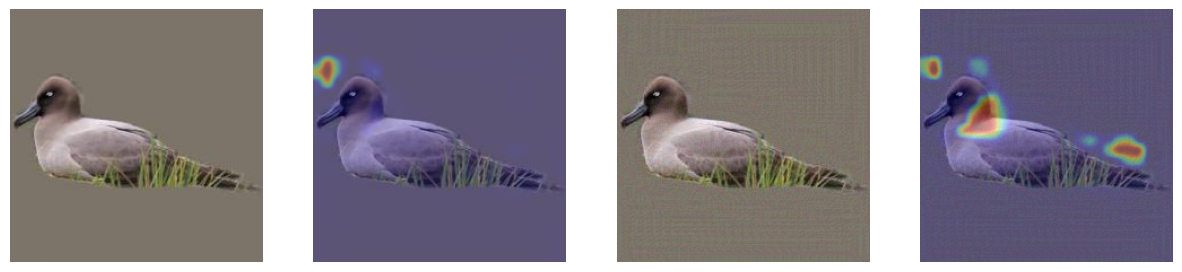

success 2 attempts 10 0.2
Node: 053+050
success 2 attempts 15 0.13333333333333333
success 2 attempts 20 0.1


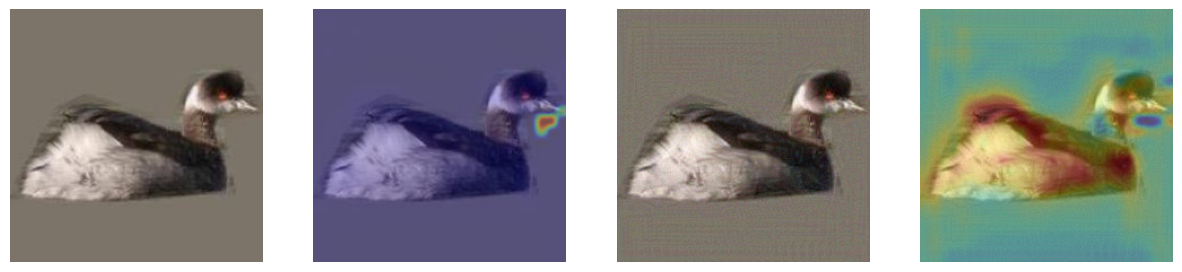

success 3 attempts 25 0.12
Node: 004+032


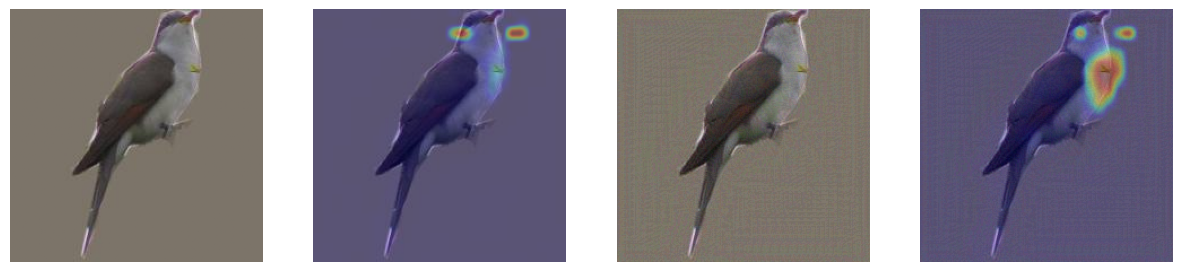

success 4 attempts 30 0.13333333333333333
Node: 050+051


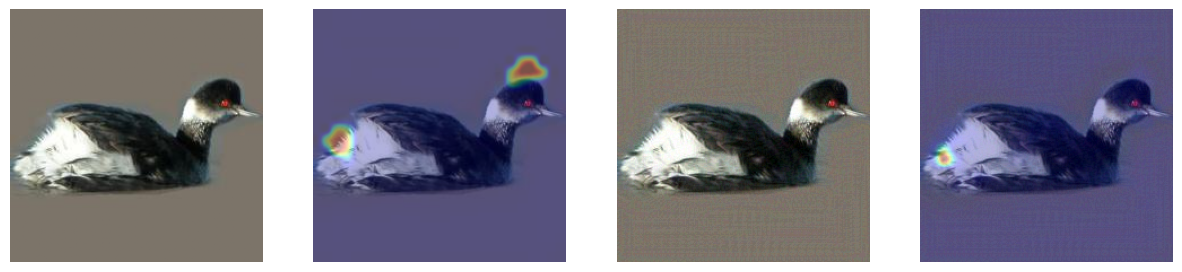

success 9 attempts 35 0.2571428571428571


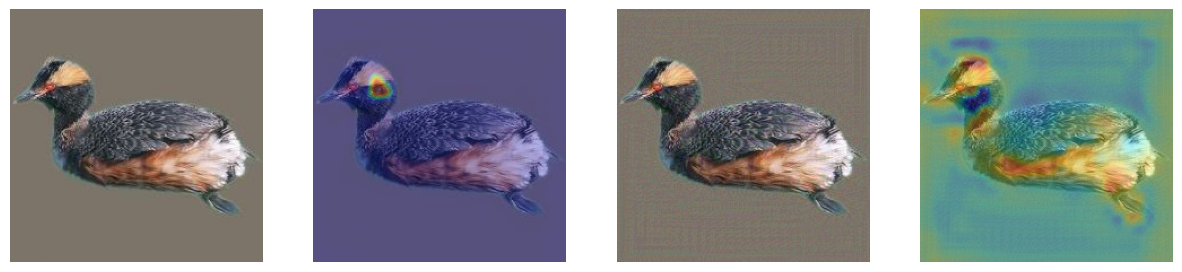

success 11 attempts 40 0.275


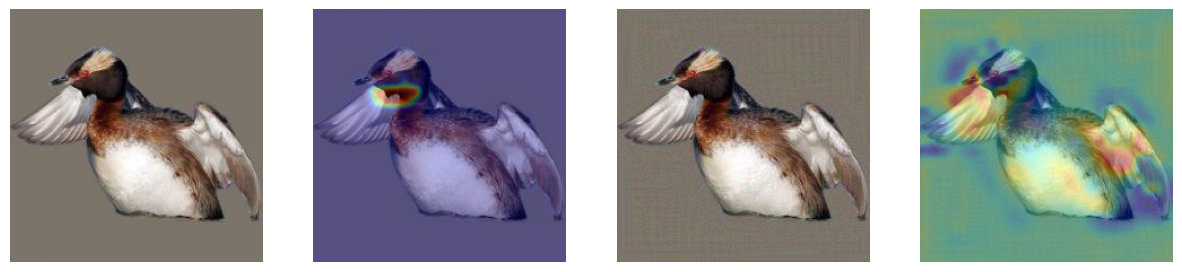

success 14 attempts 45 0.3111111111111111
Node: 032+033


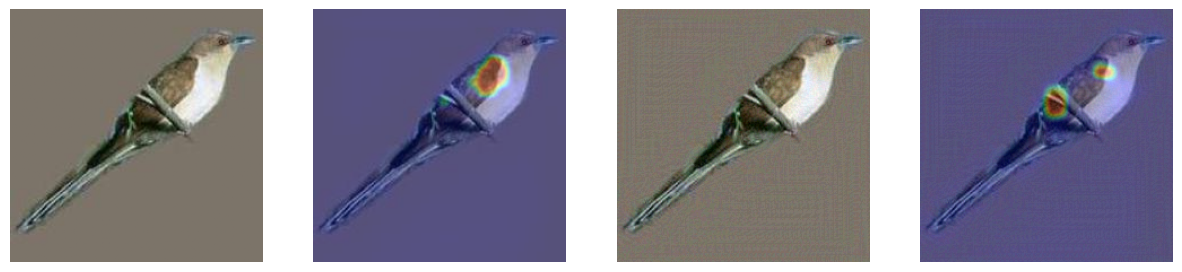

success 19 attempts 50 0.38


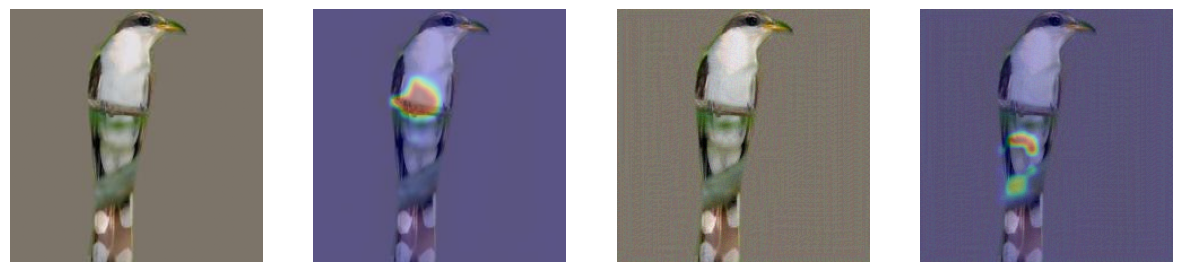

success 22 attempts 55 0.4
Node: 045+101


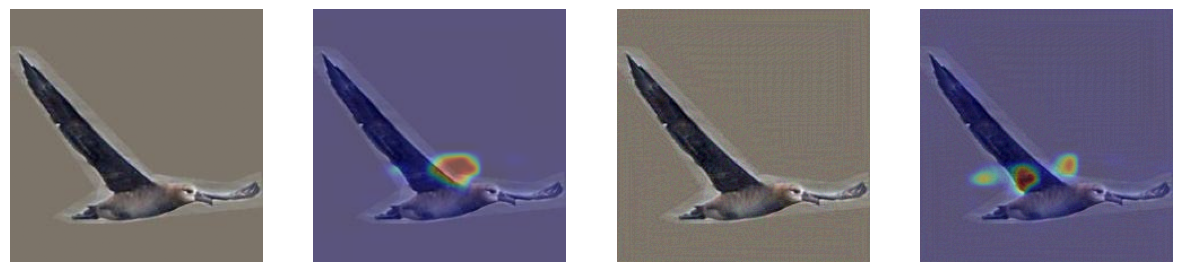

success 25 attempts 60 0.4166666666666667
success 25 attempts 65 0.38461538461538464
Node: 033+031


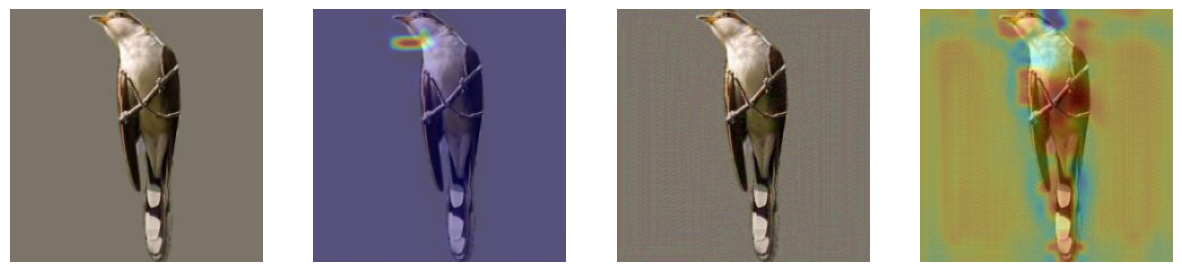

success 26 attempts 70 0.37142857142857144


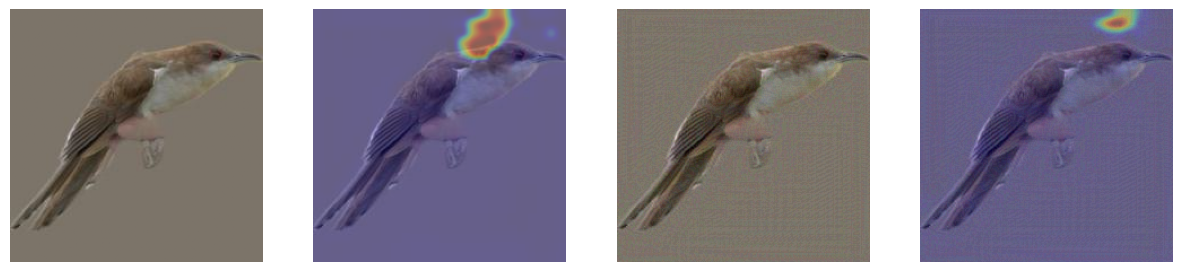

success 27 attempts 75 0.36


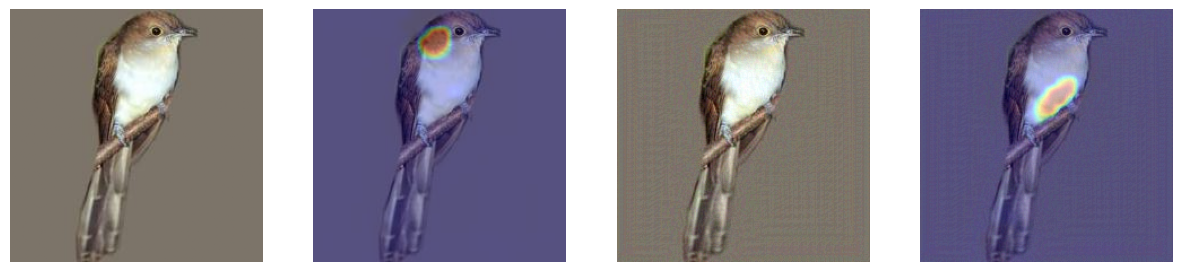

success 32 attempts 80 0.4
Node: 045+003


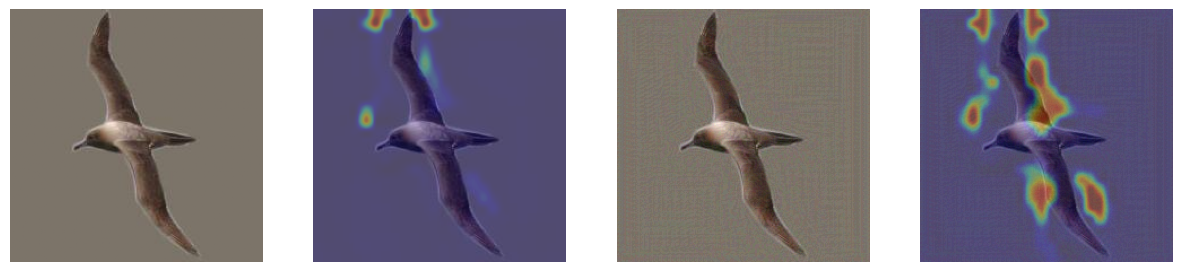

success 36 attempts 85 0.4235294117647059
Node: 101+023
success 36 attempts 90 0.4
success 36 attempts 95 0.37894736842105264
Node: 003+002


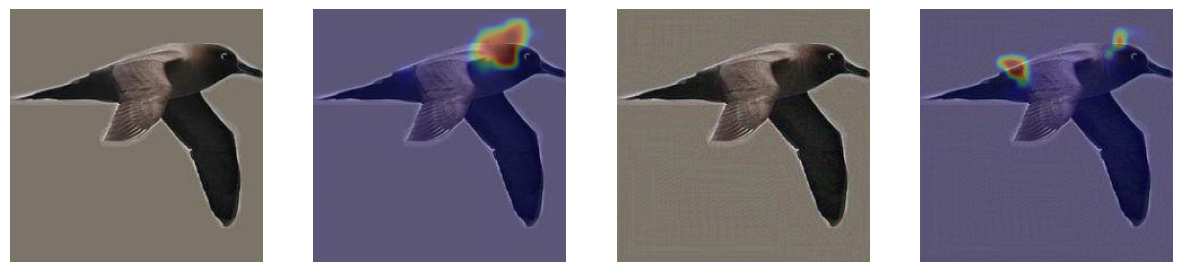

success 39 attempts 100 0.39


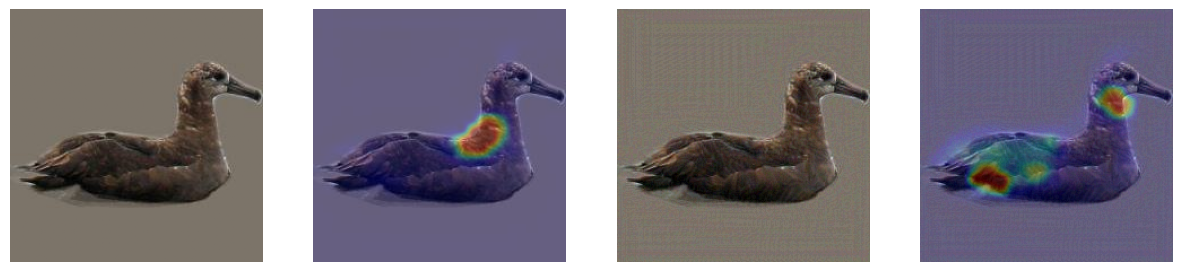

success 44 attempts 105 0.41904761904761906
Node: 101+100


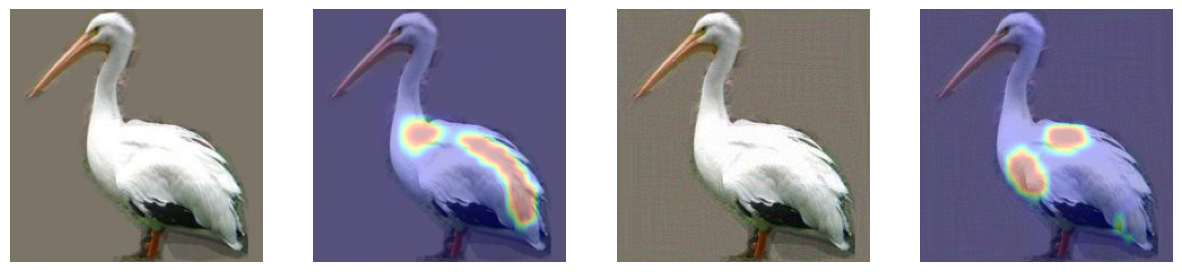

success 49 attempts 110 0.44545454545454544


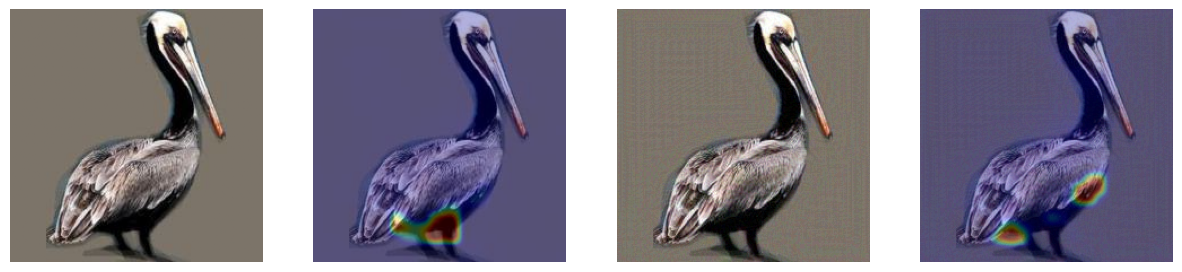

success 52 attempts 115 0.45217391304347826
Node: 023+025


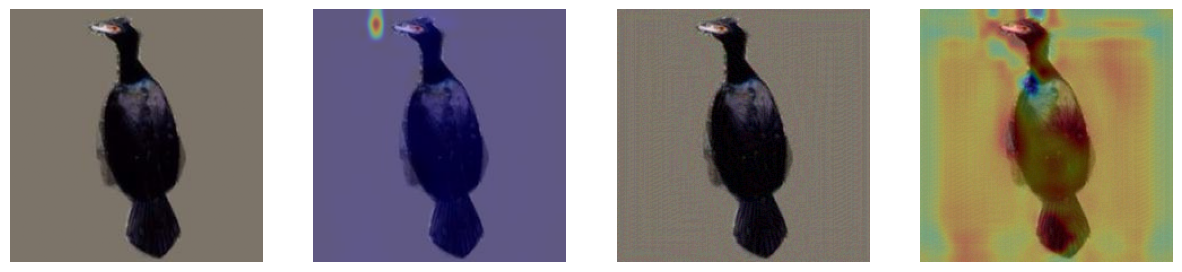

success 53 attempts 120 0.44166666666666665


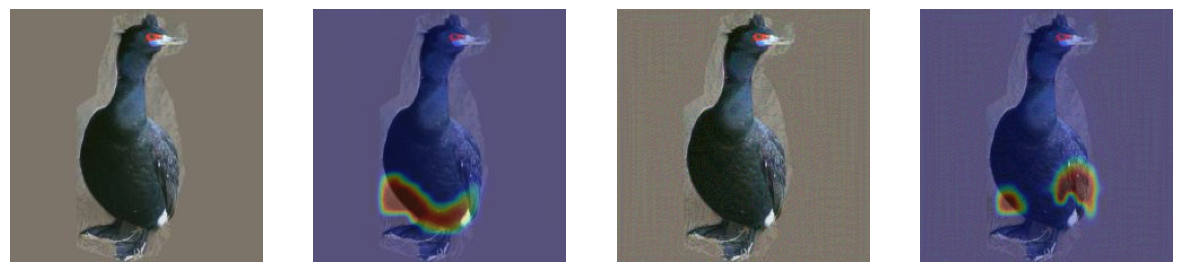

success 56 attempts 125 0.448
Node: 002+001


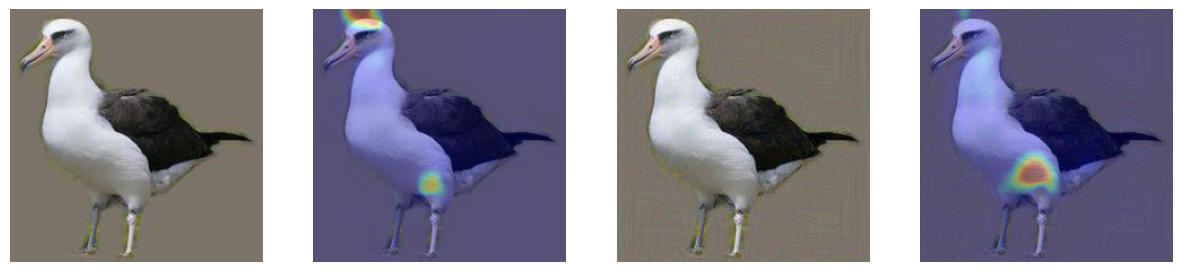

success 59 attempts 130 0.45384615384615384


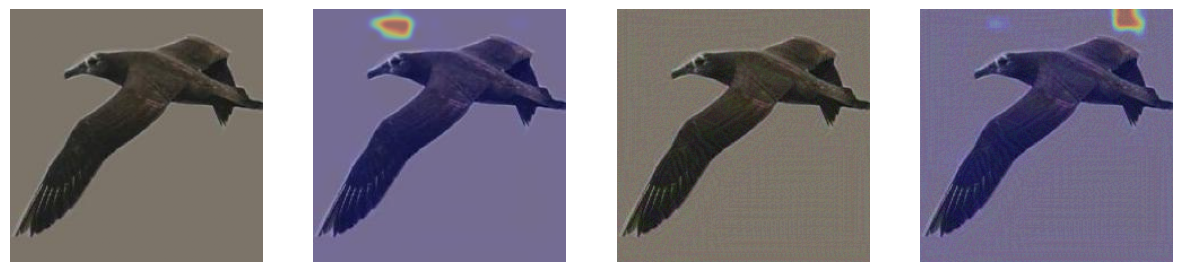

success 61 attempts 135 0.45185185185185184
Node: 025+024


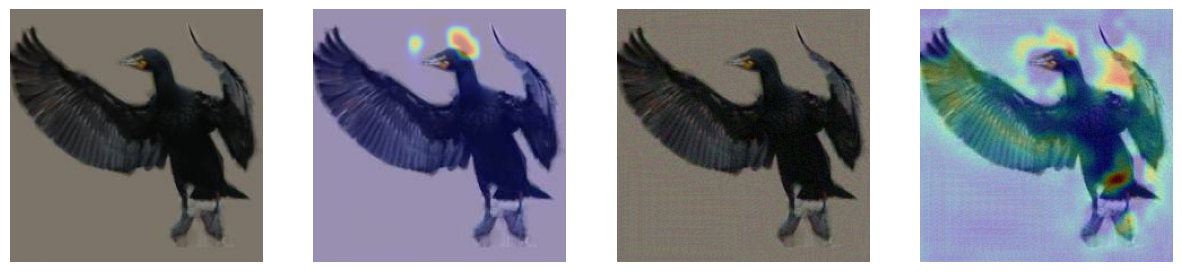

success 62 attempts 140 0.44285714285714284


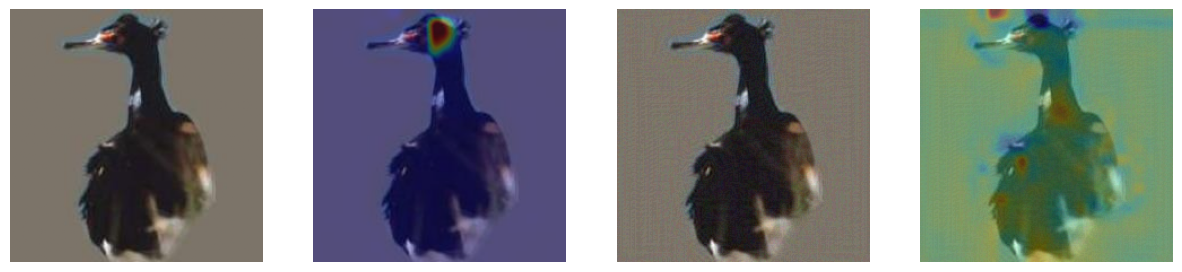

success 65 attempts 145 0.4482758620689655
success 65 attempts 150 0.43333333333333335


In [11]:
preprocess_transform = get_normalize_transform()
success = 0
attempts = 0
for node_name in node_proto_data:
    print('Node:', node_name)
    
    for proto_idx in node_proto_data[node_name]:
        displayed = False
        for peak_act, xs, img_to_open, latent_activation in node_proto_data[node_name][proto_idx]:
            
            assert latent_activation.shape[0] == 1
            latent_activation = latent_activation.unsqueeze(0)
            
            succeeded, original_image, activation_map, adversarial_image, adversarial_activation_map \
                                                         = adversarial_attack(net, 
                                                           node_name, 
                                                           proto_idx, 
                                                           xs, 
                                                           preprocess_transform, 
                                                           num_steps=100, 
                                                           epsilon=0.00008, #0.0001, #8/255, 
                                                           alpha=0.01, #2/255, 
                                                           random_init=True)
            if succeeded:
                success += 1
            attempts += 1
            
            if succeeded and not displayed:
                original_overlayed = get_heatmap(activation_map.detach().cpu(), original_image.detach().cpu().squeeze(0))
                adversarial_overlayed = get_heatmap(adversarial_activation_map.detach().cpu(), adversarial_image.detach().cpu().squeeze(0))
                plt.figure(figsize=(15, 10))
                for i, display_image in enumerate([original_image.detach().cpu().squeeze(0).permute(1, 2, 0), \
                                                   original_overlayed, \
                                                   adversarial_image.detach().cpu().squeeze(0).permute(1, 2, 0), \
                                                   adversarial_overlayed]):
                    plt.subplot(1, 4, i+1)
                    plt.imshow(display_image)
                    plt.axis('off')
                plt.show()
                displayed = True
                
        print('success', success, 'attempts', attempts, success/attempts)
                


In [102]:
success/attempts

0.20714285714285716

In [87]:
success/attempts

0.215625